# Импорт библиотек и модулей для расчета 

In [1]:
import numpy as np 
import sys
import os
from scipy import optimize
import CoolProp.CoolProp as CP
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
import glob
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

# Импорт класса расчета 
from class_DpDz import DpDz

Зададим общее количество расчетных точек

In [2]:
Nx = 50

# Исследование зависимости градиента давления от паросодерания при постоянной температуре

Вводим термодинамические параметры 

In [3]:
research_1 = {
        'Substance': 'CO2',
        'Temperature': -10,
        'x': np.linspace(0.1, 0.9, Nx),
        'G': np.array([300, 400, 500, 600])
        }

Создадим экземпляр класса расчета и зададим параметры установки 

In [4]:
first_experimental_setup = DpDz(g=0, ki=None, d=0.00142, value_fb=False, thermodynamic_params=research_1)

Запишем данные расчета в df 

In [5]:
results_of_first_research = []
for idx, (G, res) in enumerate(zip(research_1['G'], first_experimental_setup.calculate())):
    df = pd.DataFrame(res)
    df['G'] = G
    results_of_first_research.append(df)

Зададим путь к папке с экспериментальными данными

In [6]:
graph_9 = Path("./Datasets/Graph9")

Запишем экспериментальные данные в df

In [7]:
exp_df_9 = []
for file_path in graph_9.rglob('*'):
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            exp_df_9.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")

Построим графики для сравнения расчетных и экспериментальных данных 

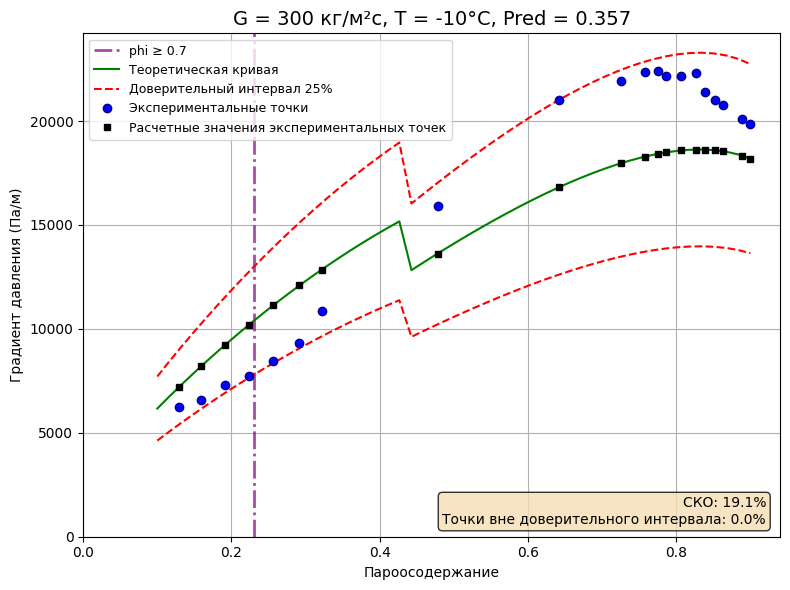

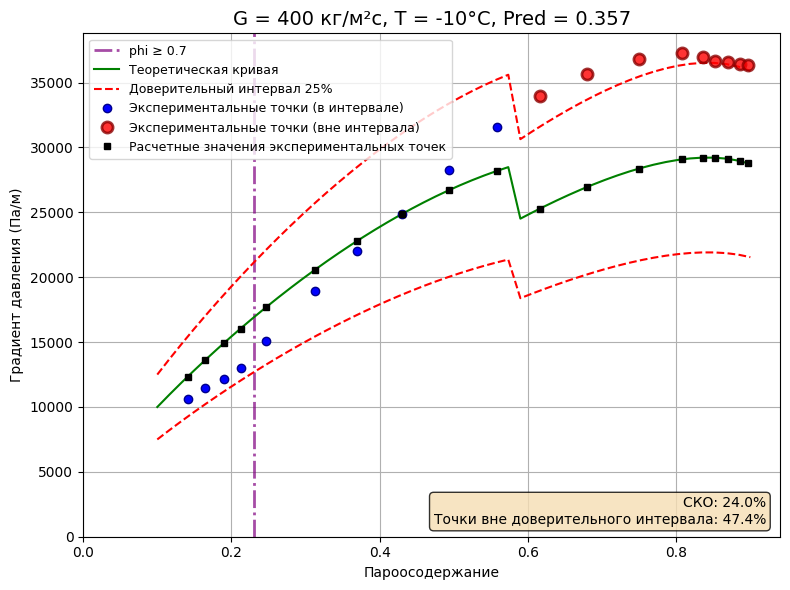

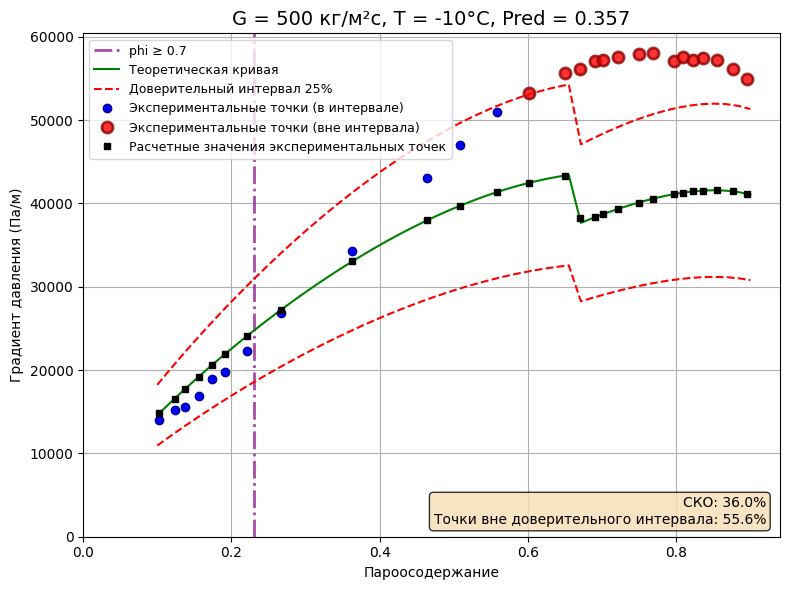

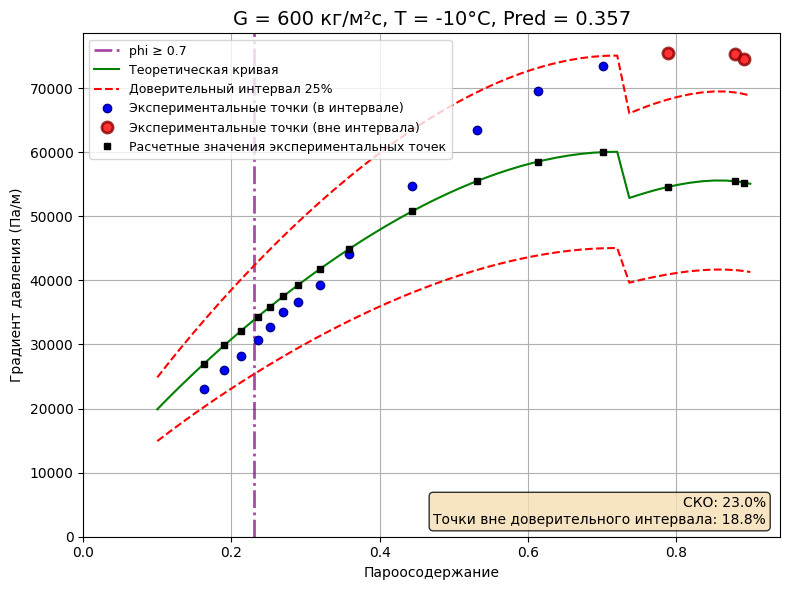


Результаты анализа отклонений:
G (кг/м²с)   СКО (%)      Точки вне 25% (%)   
----------------------------------------------------------------------
300          19.1         0.0                 
400          24.0         47.4                
500          36.0         55.6                
600          23.0         18.8                


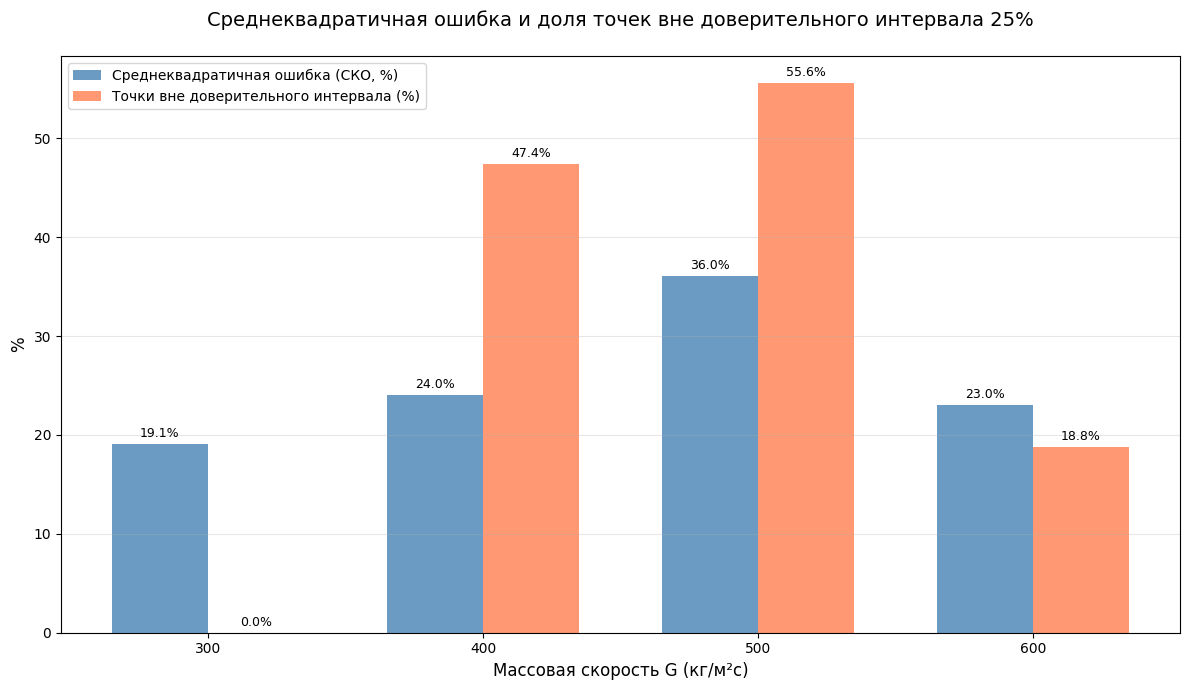

In [8]:
# Создаем списки для хранения данных по каждому эксперименту для статистики
g_values = []
rmse_percentages = []
out_of_range_percentages = []

# Часть 1: Основные графики - каждый отдельно
for i in range(len(results_of_first_research)):
    # Создаем новый рисунок для каждого графика
    fig = plt.figure(figsize=(8, 6))
    
    x = research_1['x']
    y = results_of_first_research[i]['DpDz']
    x_exp = exp_df_9[i]['X']
    y_exp = exp_df_9[i]['Y'] * 1000
    
    # Проверка наличия колонки 'fi' и добавление вертикальной линии
    if 'fi' in results_of_first_research[i].columns and (results_of_first_research[i]['fi'] >= 0.7).any():
        # Находим индекс первого значения fi >= 0.7
        first_fi_idx = results_of_first_research[i][results_of_first_research[i]['fi'] >= 0.7].index[0]
        # Получаем соответствующее значение x для этого индекса
        x_fi_line = x[first_fi_idx] if first_fi_idx < len(x) else x[-1]
        # Добавляем вертикальную линию
        plt.axvline(x=x_fi_line, color='purple', linestyle='-.', linewidth=2, alpha=0.7, label='phi ≥ 0.7')
    
    # Определяем диапазон X теоретической кривой
    x_min, x_max = np.min(x), np.max(x)
    
    # Создаем маску для точек, X-координаты которых находятся в пределах кривой
    mask_in_range = (x_exp >= x_min) & (x_exp <= x_max)
    
    # Инициализируем переменные
    x_exp_in_range = None
    y_exp_in_range = None
    y_projected_in_range = None
    y_lower_exp = None
    y_upper_exp = None
    rmse_percent = 0
    out_of_range_percent = 0
    out_of_range_mask = None
    
    # Берем только точки, которые попадают в диапазон кривой
    if np.sum(mask_in_range) > 0:
        x_exp_in_range = x_exp[mask_in_range]
        y_exp_in_range = y_exp[mask_in_range]
        
        # Создаем интерполяционную функцию для теоретической кривой
        interp_func = interp1d(x, y, kind='linear', fill_value='extrapolate')
        
        # Проектируем точки на теоретическую кривую
        y_projected_in_range = interp_func(x_exp_in_range)
        
        # 1. Расчет RMSE с использованием scikit-learn
        # Вычисляем абсолютный RMSE
        rmse_absolute = np.sqrt(mean_squared_error(y_exp_in_range, y_projected_in_range))
        
        # Преобразуем в относительный RMSE в процентах
        rmse_percent = (rmse_absolute / np.mean(y_projected_in_range)) * 100
        
        # 2. Расчет доли точек вне доверительного интервала 25%
        # ГРАВИЧНО: сравниваем фактические точки с доверительным интервалом
        # Создаем интерполяционные функции для границ доверительного интервала
        y_lower = 0.75 * y  # Нижняя граница доверительного интервала
        y_upper = 1.25 * y  # Верхняя граница доверительного интервала
        
        interp_lower = interp1d(x, y_lower, kind='linear', fill_value='extrapolate')
        interp_upper = interp1d(x, y_upper, kind='linear', fill_value='extrapolate')
        
        # Получаем значения границ для экспериментальных точек
        y_lower_exp = interp_lower(x_exp_in_range)
        y_upper_exp = interp_upper(x_exp_in_range)
        
        # Определяем, какие точки находятся вне доверительного интервала
        # Точка находится вне интервала, если она ниже нижней границы ИЛИ выше верхней границы
        out_of_range_mask = (y_exp_in_range < y_lower_exp) | (y_exp_in_range > y_upper_exp)
        
        out_of_range_points = np.sum(out_of_range_mask)
        total_points_in_range = len(y_exp_in_range)
        out_of_range_percent = (out_of_range_points / total_points_in_range) * 100 if total_points_in_range > 0 else 0
        
        # Сохраняем значения
        g_values.append(research_1['G'][i])
        rmse_percentages.append(rmse_percent)
        out_of_range_percentages.append(out_of_range_percent)
    
    # Теоретическая кривая - ЗЕЛЕНАЯ
    plt.plot(x, y, label='Теоретическая кривая', color='green')
    
    # Диапазон ошибки 25%
    plt.plot(x, 0.75 * y, color='red', linestyle='--', label='Доверительный интервал 25%')
    plt.plot(x, 1.25 * y, color='red', linestyle='--')
    
    # Экспериментальные точки - СИНИЕ (в интервале) и КРАСНЫЕ (вне интервала)
    if x_exp_in_range is not None and len(x_exp_in_range) > 0:
        # Определяем точки внутри и вне интервала
        if out_of_range_mask is not None and np.any(out_of_range_mask):
            # Разделяем точки на те, что внутри и вне интервала
            x_in_range = x_exp_in_range[~out_of_range_mask]
            y_in_range = y_exp_in_range[~out_of_range_mask]
            x_out_range = x_exp_in_range[out_of_range_mask]
            y_out_range = y_exp_in_range[out_of_range_mask]
            
            # Точки внутри интервала - СИНИЕ кружки
            if len(x_in_range) > 0:
                plt.plot(x_in_range, y_in_range, marker='o', linestyle='', 
                         label='Экспериментальные точки (в интервале)', 
                         color='blue', markersize=6, markeredgecolor='darkblue', markeredgewidth=1)
            
            # Точки вне интервала - КРАСНЫЕ кружки с более толстой границей
            if len(x_out_range) > 0:
                plt.plot(x_out_range, y_out_range, marker='o', linestyle='', 
                         label='Экспериментальные точки (вне интервала)', 
                         color='red', markersize=8, markeredgecolor='darkred', 
                         markeredgewidth=2, alpha=0.8)
        else:
            # Все точки внутри интервала - только СИНИЕ
            plt.plot(x_exp_in_range, y_exp_in_range, marker='o', linestyle='', 
                     label='Экспериментальные точки', 
                     color='blue', markersize=6, markeredgecolor='darkblue', markeredgewidth=1)
        
        # Проекции на теоретической кривой - ЧЕРНЫЕ квадраты
        plt.plot(x_exp_in_range, y_projected_in_range, 
                 marker='s', linestyle='', color='black', markersize=5, 
                 label='Расчетные значения экспериментальных точек')
    

    plt.title(f'G = {research_1["G"][i]} кг/м²с, T = {research_1["Temperature"]}°C, Pred = {results_of_first_research[i]["Pred"].mean():.3f}', fontsize=14)
    plt.xlabel('Пароосодержание')
    plt.ylabel('Градиент давления (Па/м)')
    
    # ЛЕГЕНДА В ВЕРХНЕМ ЛЕВОМ УГЛУ
    plt.legend(loc='upper left', fontsize=9)
    
    # СЕТКА НАЧИНАЕТСЯ С 0 ТОЛЬКО ПО ОСИ X
    plt.grid(True, which='both')
    

    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    # ДОБАВЛЯЕМ ТАБЛИЧКУ СТАТИСТИКИ В НИЖНЕМ ПРАВОМ УГЛУ
    # Устанавливаем отступы, чтобы табличка не наезжала на оси
    plt.subplots_adjust(bottom=0.15, right=0.85)
    
    # Если есть данные для статистики, добавляем табличку
    if x_exp_in_range is not None and len(x_exp_in_range) > 0:
        # Определяем позицию в правом нижнем углу с учетом отступов
        plt.figtext(0.98, 0.02, 
                   f'СКО: {rmse_percent:.1f}%\nТочки вне доверительного интервала: {out_of_range_percent:.1f}%',
                   ha='right', va='bottom', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                   transform=plt.gca().transAxes)
    
    plt.tight_layout()
    
    # Показываем график
    plt.show()

# Часть 2: Столбчатая диаграмма с расчетами
if len(g_values) > 0:
    # Создаем новый рисунок для столбчатой диаграммы
    plt.figure(figsize=(12, 7))
    
    # Настройки позиций для столбцов
    x = np.arange(len(g_values))
    width = 0.35
    
    # Столбцы для RMSE
    bars1 = plt.bar(x - width/2, rmse_percentages, width, 
                   label='Среднеквадратичная ошибка (СКО, %)', color='steelblue', alpha=0.8)
    
    # Столбцы для точек вне интервала
    bars2 = plt.bar(x + width/2, out_of_range_percentages, width, 
                   label='Точки вне доверительного интервала (%)', color='coral', alpha=0.8)
    
    # Настройка графика
    plt.xlabel('Массовая скорость G (кг/м²с)', fontsize=12)
    plt.ylabel('%', fontsize=12)
    plt.title('Среднеквадратичная ошибка и доля точек вне доверительного интервала 25%\n', 
              fontsize=14)
    plt.xticks(x, g_values)
    plt.legend(fontsize=11)
    
    # СЕТКА (по оси Y начинается с 0, так как проценты не могут быть отрицательными)
    plt.grid(True, alpha=0.3, axis='y')
    
    # УСТАНАВЛИВАЕМ ПРЕДЕЛЫ ОСИ Y, ЧТОБЫ СЕТКА НАЧИНАЛАСЬ С 0
    plt.ylim(bottom=0)
    
    # Добавляем значения над столбцами
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Смещение текста
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    
    
    plt.legend()
    plt.tight_layout()
    
    # Выводим таблицу с данными
    print("\n" + "="*70)
    print("Результаты анализа отклонений:")
    print("="*70)
    print(f"{'G (кг/м²с)':<12} {'СКО (%)':<12} {'Точки вне 25% (%)':<20}")
    print("-"*70)
    for i, (g_val, rmse_val, out_val) in enumerate(zip(g_values, rmse_percentages, out_of_range_percentages)):
        print(f"{g_val:<12} {rmse_val:<12.1f} {out_val:<20.1f}")
    
    print("="*70)
    
    # Показываем столбчатую диаграмму
    plt.show()
else:
    print("Нет точек в границах кривой для построения статистики")

In [9]:
# Создаем список для хранения данных статистики
statistics_data = []

# Проходим по всем графикам и собираем статистику
for i in range(len(results_of_first_research)):
    # Берем данные для текущего G
    x = research_1['x']
    y = results_of_first_research[i]['DpDz']
    x_exp = exp_df_9[i]['X']
    y_exp = exp_df_9[i]['Y'] * 1000
    
    # Определяем диапазон X теоретической кривой
    x_min, x_max = np.min(x), np.max(x)
    
    # Создаем маску для точек, X-координаты которых находятся в пределах кривой
    mask_in_range = (x_exp >= x_min) & (x_exp <= x_max)
    
    rmse_percent = 0
    out_of_range_percent = 0
    total_points_in_range = 0
    out_of_range_points = 0
    
    # Если есть точки в диапазоне кривой
    if np.sum(mask_in_range) > 0:
        x_exp_in_range = x_exp[mask_in_range]
        y_exp_in_range = y_exp[mask_in_range]
        total_points_in_range = len(y_exp_in_range)
        
        # Создаем интерполяционную функцию для теоретической кривой
        interp_func = interp1d(x, y, kind='linear', fill_value='extrapolate')
        
        # Проектируем точки на теоретическую кривую
        y_projected_in_range = interp_func(x_exp_in_range)
        
        # Расчет RMSE
        rmse_absolute = np.sqrt(mean_squared_error(y_exp_in_range, y_projected_in_range))
        rmse_percent = (rmse_absolute / np.mean(y_projected_in_range)) * 100
        
        # Расчет точек вне доверительного интервала 25%
        y_lower = 0.75 * y  # Нижняя граница доверительного интервала
        y_upper = 1.25 * y  # Верхняя граница доверительного интервала
        
        interp_lower = interp1d(x, y_lower, kind='linear', fill_value='extrapolate')
        interp_upper = interp1d(x, y_upper, kind='linear', fill_value='extrapolate')
        
        # Получаем значения границ для экспериментальных точек
        y_lower_exp = interp_lower(x_exp_in_range)
        y_upper_exp = interp_upper(x_exp_in_range)
        
        # Определяем, какие точки находятся вне доверительного интервала
        out_of_range_mask = (y_exp_in_range < y_lower_exp) | (y_exp_in_range > y_upper_exp)
        out_of_range_points = np.sum(out_of_range_mask)
        out_of_range_percent = (out_of_range_points / total_points_in_range) * 100 if total_points_in_range > 0 else 0
    
    # Добавляем данные статистики для этого графика
    statistics_data.append({
        'G, кг/м²с': research_1['G'][i],
        'Эксп. точек в режиме': total_points_in_range,
        'Эксп. точек вне доверительного интервала': out_of_range_points,
        '% вне доверительного интервала': f'{out_of_range_percent:.1f}%',
        'СКО, %': f'{rmse_percent:.1f}%',
        'T, °C': research_1['Temperature']
    })

# Создаем DataFrame
statistics_table = pd.DataFrame(statistics_data)

# Добавляем итоговую строку
total_exp_points = statistics_table['Эксп. точек в режиме'].sum()
total_out_points = statistics_table['Эксп. точек вне доверительного интервала'].sum()
total_percentage = (total_out_points / total_exp_points * 100) if total_exp_points > 0 else 0

# Вычисляем среднее СКО (взвешенное по количеству точек)
weighted_rmse = 0
if total_exp_points > 0:
    for idx, row in statistics_table.iterrows():
        rmse_val = float(row['СКО, %'].replace('%', ''))
        exp_points = row['Эксп. точек в режиме']
        weighted_rmse += rmse_val * exp_points / total_exp_points

total_row = {
    'G, кг/м²с': 'ИТОГО',
    'Эксп. точек в режиме': total_exp_points,
    'Эксп. точек вне доверительного интервала': total_out_points,
    '% вне доверительного интервала': f'{total_percentage:.1f}%',
    'СКО, %': f'{weighted_rmse:.1f}%',
    'T, °C': '-'
}

statistics_table = pd.concat([statistics_table, pd.DataFrame([total_row])], ignore_index=True)

# Выводим таблицу
print("СВОДНАЯ ТАБЛИЦА: Статистика по графикам исследования")
print("Доверительный интервал: 25% от теоретической кривой")
print("=" * 85)
display(statistics_table.style.hide(axis='index'))

СВОДНАЯ ТАБЛИЦА: Статистика по графикам исследования
Доверительный интервал: 25% от теоретической кривой


"G, кг/м²с",Эксп. точек в режиме,Эксп. точек вне доверительного интервала,% вне доверительного интервала,"СКО, %","T, °C"
300,20,0,0.0%,19.1%,-10
400,19,9,47.4%,24.0%,-10
500,27,15,55.6%,36.0%,-10
600,16,3,18.8%,23.0%,-10
ИТОГО,82,27,32.9%,26.6%,-


Сохранение результатов 

In [10]:

# Создаем основную папку Results если нет
os.makedirs('./Results', exist_ok=True)

for result in results_of_first_research:
    try:
        # Название вещества
        sub = result['Substance'].unique()[0]
        
        # Параметр (температура) для имени файла
        par = result['G'].unique()[0]
        
        # Директория для сохранения: Results/вещество/T
        output_dir = f'./Results/{sub}/G'
        
        # Создаем директорию если нет
        os.makedirs(output_dir, exist_ok=True)
        
        # Сохраняем каждый df с именем параметра (температуры)
        result.to_csv(f'{output_dir}/{par}.csv', index=True)
        
    except IndexError:
        print(f"Ошибка: Пустой DataFrame в results_of_second_research")
    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")

# Удаляем старые файлы только после сохранения всех новых
# Или удаляем перед началом цикла (раскомментируйте нужный вариант):

# Вариант 2: Удалить старые файлы которые не соответствуют новым данным (рекомендуется)
existing_files = set()
for result in results_of_first_research:
    sub = result['Substance'].unique()[0]
    par = result['G'].unique()[0]
    existing_files.add(f'./Results/{sub}/T/{par}.csv')

# Удаляем файлы которых нет в новых данных
for result in results_of_first_research:
    sub = result['Substance'].unique()[0]
    output_dir = f'./Results/{sub}/T'
    if os.path.exists(output_dir):
        for file in glob.glob(os.path.join(output_dir, '*.csv')):
            if file not in existing_files:
                os.remove(file)

# Исследование зависимости градиента давления от паросодерания при постоянном расходе

Зададим путь к папке с экспериментальными данным

In [11]:
graph_12 = Path("./Datasets/Graph12")

Получим экспериментальные данные 

In [12]:
data = []
# Числовой порядок для Gr файлов
gr_files = [f for f in graph_12.rglob('*.csv')]
gr_files_sorted = sorted(gr_files, key=lambda x: int(x.stem[:]))

for file_path in gr_files_sorted:
    if file_path.is_file():
        try:
            write = pd.read_csv(file_path, sep='\t', decimal='.')
            data.append(write)
        except Exception as e:
            print(f"Ошибка: {e}")


Зададим массив исследуемых температур

In [13]:
T = np.array([0, -10, -20, -30, -35, -40])

Изменяя параметры в цикле рассчитаем зависимость для каждой температуры

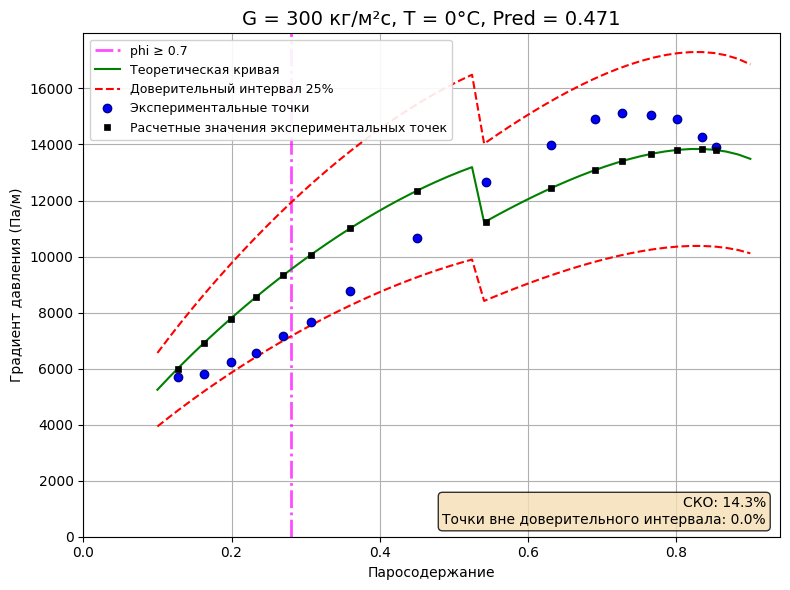

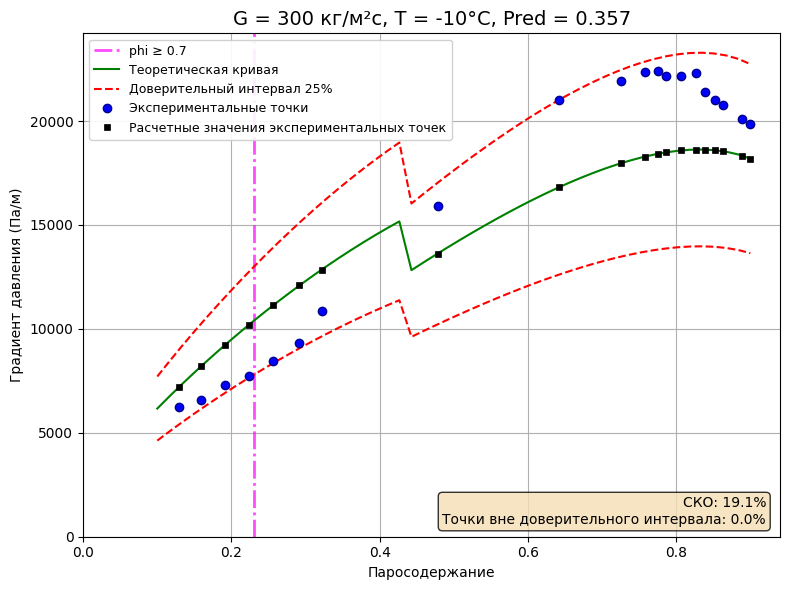

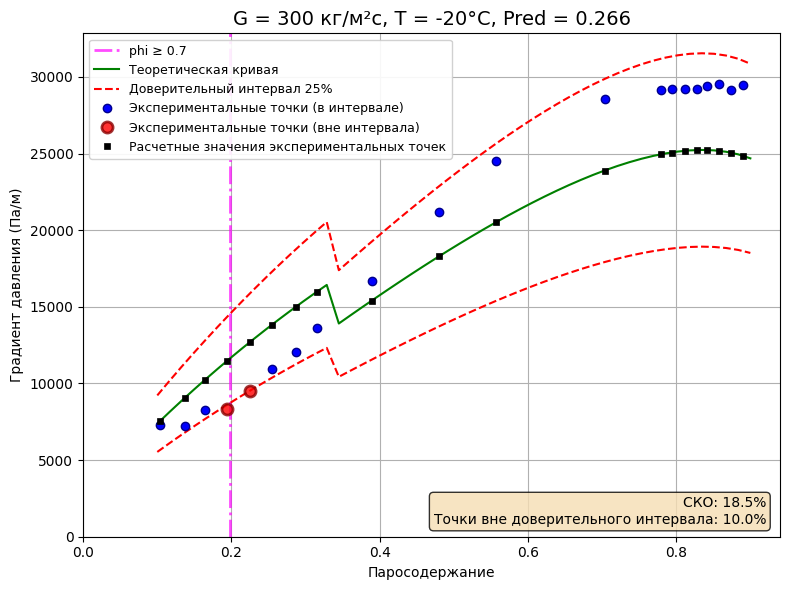

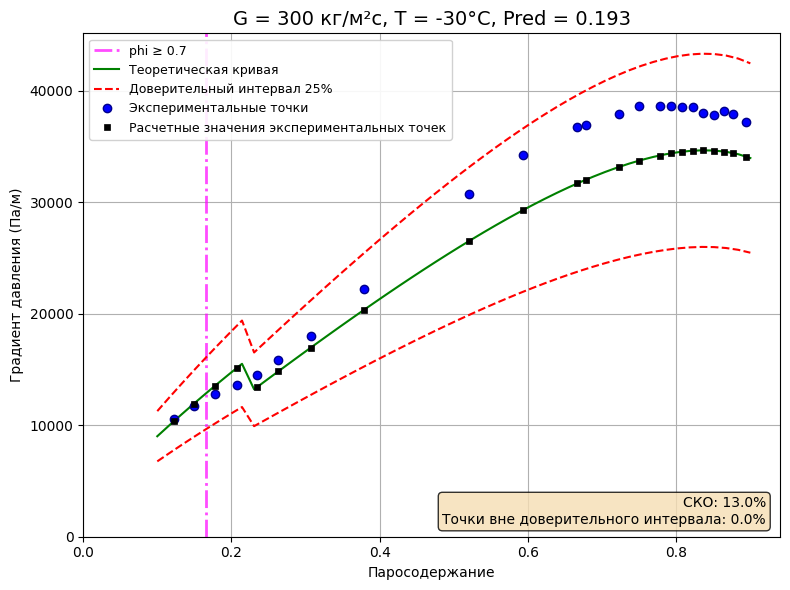

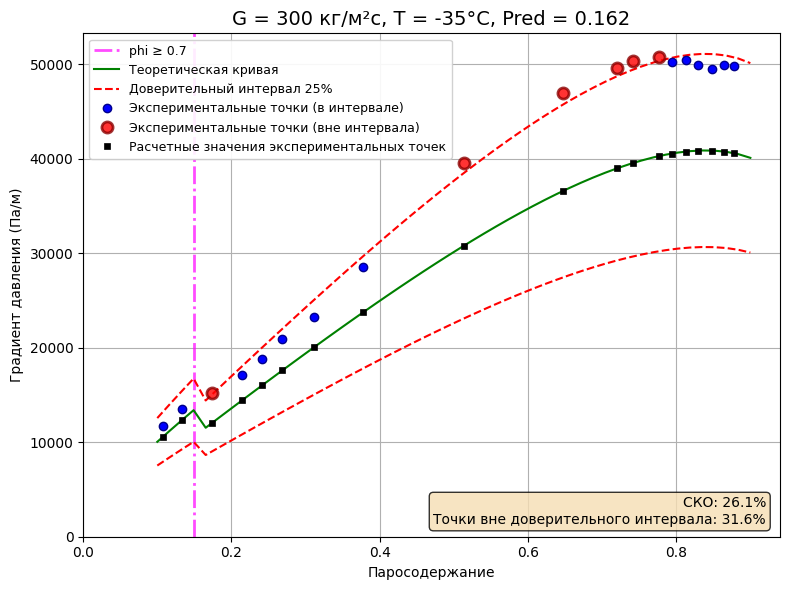

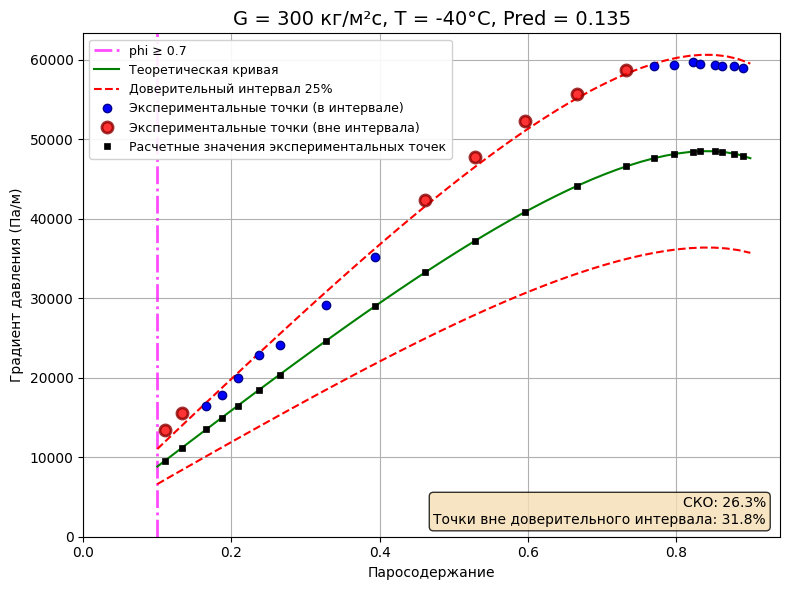

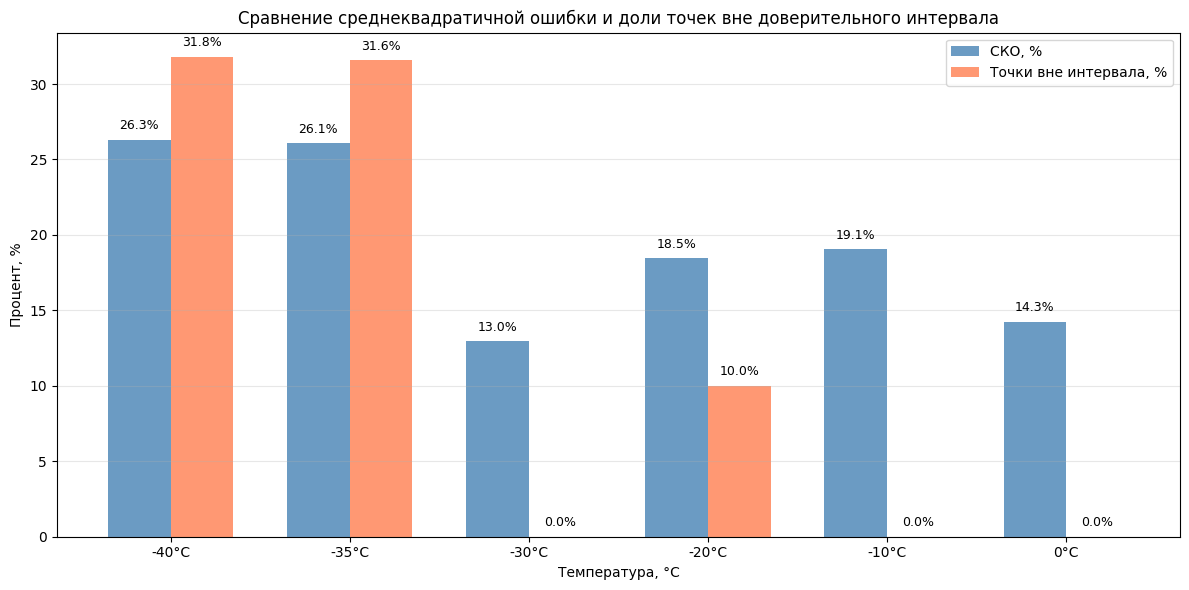

СВОДНАЯ СТАТИСТИКА ПО ВСЕМ ТЕМПЕРАТУРАМ
Температура (°C)     СКО (%)         Точки вне интервала (%)  
------------------------------------------------------------
0                    14.3            0.0                      
-10                  19.1            0.0                      
-20                  18.5            10.0                     
-30                  13.0            0.0                      
-35                  26.1            31.6                     
-40                  26.3            31.8                     
------------------------------------------------------------
Среднее:             19.5            12.2                     
Максимум:            26.3            31.8                     
Минимум:             13.0            0.0                      


In [14]:
# Создаем списки для хранения данных для статистики
t_values = []
rmse_percentages = []
out_of_range_percentages = []
results_of_second_research = []

# Создаем графики по отдельности для каждой температуры
for i, t in enumerate(T):
    # Создаем новый график для каждой температуры
    fig = plt.figure(figsize=(8, 6))
    
    # Расчет параметров
    params_t = {
        'Substance': 'CO2',
        'Temperature': t,
        'G': 300,
        'x': np.linspace(0.1, 0.9, Nx),
    }
    
    second_experimental_setup = DpDz(g=0, ki=None, d=0.00142, value_fb=False, thermodynamic_params=params_t)
    values = second_experimental_setup.calculate()
    
    # Сохраняем результаты
    df = pd.DataFrame(values)
    df['G'] = params_t['G']
    df['T'] = params_t['Temperature']
    results_of_second_research.append(df)

    # Получаем данные для построения
    x = params_t['x']
    y = df['DpDz']
    x_exp = data[i]['X']
    y_exp = data[i]['Y'] * 1000  # Конвертация в Па/м
    
    # Определяем диапазон X теоретической кривой
    x_min, x_max = np.min(x), np.max(x)
    
    # Создаем маску для точек, X-координаты которых находятся в пределах кривой
    mask_in_range = (x_exp >= x_min) & (x_exp <= x_max)
    
    # Инициализируем переменные
    x_exp_in_range = None
    y_exp_in_range = None
    y_projected_in_range = None
    y_lower_exp = None
    y_upper_exp = None
    rmse_percent = 0
    out_of_range_percent = 0
    out_of_range_mask = None
    
    # Берем только точки, которые попадают в диапазон кривой
    if np.sum(mask_in_range) > 0:
        x_exp_in_range = x_exp[mask_in_range]
        y_exp_in_range = y_exp[mask_in_range]
        
        # Создаем интерполяционную функцию для теоретической кривой
        interp_func = interp1d(x, y, kind='linear', fill_value='extrapolate')
        
        # Проектируем точки на теоретическую кривую
        y_projected_in_range = interp_func(x_exp_in_range)
        
        # 1. Расчет RMSE
        rmse_absolute = np.sqrt(mean_squared_error(y_exp_in_range, y_projected_in_range))
        rmse_percent = (rmse_absolute / np.mean(y_projected_in_range)) * 100
        
        # 2. Расчет доли точек вне доверительного интервала 25%
        # ГРАВИЧНО: сравниваем фактические точки с доверительным интервалом
        # Создаем интерполяционные функции для границ доверительного интервала
        y_lower = 0.75 * y  # Нижняя граница доверительного интервала
        y_upper = 1.25 * y  # Верхняя граница доверительного интервала
        
        interp_lower = interp1d(x, y_lower, kind='linear', fill_value='extrapolate')
        interp_upper = interp1d(x, y_upper, kind='linear', fill_value='extrapolate')
        
        # Получаем значения границ для экспериментальных точек
        y_lower_exp = interp_lower(x_exp_in_range)
        y_upper_exp = interp_upper(x_exp_in_range)
        
        # Определяем, какие точки находятся вне доверительного интервала
        # Точка находится вне интервала, если она ниже нижней границы ИЛИ выше верхней границы
        out_of_range_mask = (y_exp_in_range < y_lower_exp) | (y_exp_in_range > y_upper_exp)
        
        out_of_range_points = np.sum(out_of_range_mask)
        total_points_in_range = len(y_exp_in_range)
        out_of_range_percent = (out_of_range_points / total_points_in_range) * 100 if total_points_in_range > 0 else 0
        
        # Сохраняем значения для статистики
        t_values.append(t)
        rmse_percentages.append(rmse_percent)
        out_of_range_percentages.append(out_of_range_percent)
    
    # ДОБАВЛЕНО: Построение вертикальной линии при первом df['fi'] >= 0.7
    if 'fi' in df.columns and (df['fi'] >= 0.7).any():
        # Находим индекс первого значения fi >= 0.7
        first_fi_idx = df[df['fi'] >= 0.7].index[0]
        # Получаем соответствующее значение x для этого индекса
        x_fi_line = x[first_fi_idx]
        # Добавляем вертикальную линию
        plt.axvline(x=x_fi_line, color='magenta', linestyle='-.', linewidth=2, alpha=0.7, label='phi ≥ 0.7')
    
    # Построение графиков с цветовой схемой как на картинке
    
    # 1. Теоретическая кривая - ЗЕЛЕНАЯ сплошная линия
    plt.plot(x, y, label='Теоретическая кривая', color='green')
    
    
    # 2. Доверительный интервал 25% - КРАСНЫЕ пунктирные линии
    plt.plot(x, 0.75 * y, color='red', linestyle='--', label='Доверительный интервал 25%')
    plt.plot(x, 1.25 * y, color='red', linestyle='--')
    
    # 3. Экспериментальные точки - СИНИЕ точки (в интервале) и КРАСНЫЕ (вне интервала)
    if x_exp_in_range is not None and len(x_exp_in_range) > 0:
        # Определяем точки внутри и вне интервала
        if out_of_range_mask is not None and np.any(out_of_range_mask):
            # Разделяем точки на те, что внутри и вне интервала
            x_in_range = x_exp_in_range[~out_of_range_mask]
            y_in_range = y_exp_in_range[~out_of_range_mask]
            x_out_range = x_exp_in_range[out_of_range_mask]
            y_out_range = y_exp_in_range[out_of_range_mask]
            
            # Точки внутри интервала - СИНИЕ кружки
            if len(x_in_range) > 0:
                plt.plot(x_in_range, y_in_range, marker='o', linestyle='', 
                         label='Экспериментальные точки (в интервале)', 
                         color='blue', markersize=6, markeredgecolor='darkblue', markeredgewidth=1)
            
            # Точки вне интервала - КРАСНЫЕ кружки с более толстой границей
            if len(x_out_range) > 0:
                plt.plot(x_out_range, y_out_range, marker='o', linestyle='', 
                         label='Экспериментальные точки (вне интервала)', 
                         color='red', markersize=8, markeredgecolor='darkred', 
                         markeredgewidth=2, alpha=0.8)
        else:
            # Все точки внутри интервала - только СИНИЕ
            plt.plot(x_exp_in_range, y_exp_in_range, marker='o', linestyle='', 
                     label='Экспериментальные точки', 
                     color='blue', markersize=6, markeredgecolor='darkblue', markeredgewidth=1)
        
        # 4. Проекции на теоретической кривой - ЧЕРНЫЕ квадраты
        plt.plot(x_exp_in_range, y_projected_in_range, 
                 marker='s', linestyle='', color='black', markersize=5, 
                 label='Расчетные значения экспериментальных точек', markeredgewidth=0.5)
    
    # Настройки осей
    plt.xlabel('Паросодержание')
    plt.ylabel('Градиент давления (Па/м)')
    
    # Основной заголовок - только T и G (как на картинке)
    plt.title(f'G = {params_t["G"]} кг/м²с, T = {t}°C, Pred = {results_of_second_research[i]["Pred"].mean():.3f}', fontsize=14)
    
    # ЛЕГЕНДА В ВЕРХНЕМ ЛЕВОМ УГЛУ
    plt.legend(loc='upper left', fontsize=9, framealpha=0.9)
    
    # СЕТКА НАЧИНАЕТСЯ С 0 ПО ОСИ X
    plt.grid(True)
    
    # УСТАНАВЛИВАЕМ ПРЕДЕЛЫ ОСИ X, ЧТОБЫ СЕТКА НАЧИНАЛАСЬ С 0
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    # Устанавливаем отступы
    plt.subplots_adjust(bottom=0.15, right=0.85)
    
    # ДОБАВЛЯЕМ ТАБЛИЧКУ СТАТИСТИКИ В НИЖНЕМ ПРАВОМ УГЛУ (как на картинке)
    # Если есть данные для статистики, добавляем табличку
    if x_exp_in_range is not None and len(x_exp_in_range) > 0:
        # Определяем позицию в правом нижнем углу
        plt.figtext(0.98, 0.02, 
                   f'СКО: {rmse_percent:.1f}%\nТочки вне доверительного интервала: {out_of_range_percent:.1f}%',
                   ha='right', va='bottom', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                   transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()



# Если у нас есть данные для статистики
if len(t_values) > 0:
    # Сортируем значения по температуре для красивого отображения
    sorted_indices = np.argsort(t_values)
    t_sorted = np.array(t_values)[sorted_indices]
    rmse_sorted = np.array(rmse_percentages)[sorted_indices]
    out_of_range_sorted = np.array(out_of_range_percentages)[sorted_indices]
    
   

# создаем комбинированный график для наглядности
fig, ax = plt.subplots(figsize=(12, 6))

if len(t_values) > 0:
    # Индексы для группировки
    x = np.arange(len(t_sorted))
    width = 0.35
    
    # Два набора столбцов
    bars1 = ax.bar(x - width/2, rmse_sorted, width, label='СКО, %', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, out_of_range_sorted, width, label='Точки вне интервала, %', color='coral', alpha=0.8)
    
    ax.set_xlabel('Температура, °C')
    ax.set_ylabel('Процент, %')
    ax.set_title('Сравнение среднеквадратичной ошибки и доли точек вне доверительного интервала')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{t}°C' for t in t_sorted])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # УСТАНАВЛИВАЕМ ПРЕДЕЛЫ ОСИ Y, ЧТОБЫ СЕТКА НАЧИНАЛАСЬ С 0 (для столбчатой диаграммы это важно)
    ax.set_ylim(bottom=0)
    
    # Добавляем значения на столбцы
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)

plt.tight_layout()
plt.show()

# Выводим сводную статистику в табличном виде
print("="*60)
print("СВОДНАЯ СТАТИСТИКА ПО ВСЕМ ТЕМПЕРАТУРАМ")
print("="*60)
print(f"{'Температура (°C)':<20} {'СКО (%)':<15} {'Точки вне интервала (%)':<25}")
print("-"*60)

for i in range(len(t_values)):
    print(f"{t_values[i]:<20} {rmse_percentages[i]:<15.1f} {out_of_range_percentages[i]:<25.1f}")

print("-"*60)
print(f"{'Среднее:':<20} {np.mean(rmse_percentages):<15.1f} {np.mean(out_of_range_percentages):<25.1f}")
print(f"{'Максимум:':<20} {np.max(rmse_percentages):<15.1f} {np.max(out_of_range_percentages):<25.1f}")
print(f"{'Минимум:':<20} {np.min(rmse_percentages):<15.1f} {np.min(out_of_range_percentages):<25.1f}")
print("="*60)

In [15]:
# Создаем списки для хранения данных статистики
statistics_data_temp = []

# Проходим по всем графикам и собираем статистику
for i, t in enumerate(T):
    # Создаем новый график для каждой температуры
    params_t = {
        'Substance': 'CO2',
        'Temperature': t,
        'G': 300,
        'x': np.linspace(0.1, 0.9, Nx),
    }
    
    second_experimental_setup = DpDz(g=0, ki=None, d=0.00142, value_fb=False, thermodynamic_params=params_t)
    values = second_experimental_setup.calculate()
    
    # Сохраняем результаты
    df = pd.DataFrame(values)
    df['G'] = params_t['G']
    df['T'] = params_t['Temperature']
    results_of_second_research.append(df)
    
    # Получаем данные для построения
    x = params_t['x']
    y = df['DpDz']
    x_exp = data[i]['X']
    y_exp = data[i]['Y'] * 1000  # Конвертация в Па/м
    
    # Определяем диапазон X теоретической кривой
    x_min, x_max = np.min(x), np.max(x)
    
    # Создаем маску для точек, X-координаты которых находятся в пределах кривой
    mask_in_range = (x_exp >= x_min) & (x_exp <= x_max)
    
    # Инициализируем переменные
    x_exp_in_range = None
    y_exp_in_range = None
    y_projected_in_range = None
    y_lower_exp = None
    y_upper_exp = None
    rmse_percent = 0
    out_of_range_percent = 0
    out_of_range_mask = None
    total_points_in_range = 0
    out_of_range_points = 0
    
    # Берем только точки, которые попадают в диапазон кривой
    if np.sum(mask_in_range) > 0:
        x_exp_in_range = x_exp[mask_in_range]
        y_exp_in_range = y_exp[mask_in_range]
        total_points_in_range = len(y_exp_in_range)
        
        # Создаем интерполяционную функцию для теоретической кривой
        interp_func = interp1d(x, y, kind='linear', fill_value='extrapolate')
        
        # Проектируем точки на теоретическую кривую
        y_projected_in_range = interp_func(x_exp_in_range)
        
        # 1. Расчет RMSE
        rmse_absolute = np.sqrt(mean_squared_error(y_exp_in_range, y_projected_in_range))
        rmse_percent = (rmse_absolute / np.mean(y_projected_in_range)) * 100
        
        # 2. Расчет доли точек вне доверительного интервала 25%
        # ГРАВИЧНО: сравниваем фактические точки с доверительным интервалом
        # Создаем интерполяционные функции для границ доверительного интервала
        y_lower = 0.75 * y  # Нижняя граница доверительного интервала
        y_upper = 1.25 * y  # Верхняя граница доверительного интервала
        
        interp_lower = interp1d(x, y_lower, kind='linear', fill_value='extrapolate')
        interp_upper = interp1d(x, y_upper, kind='linear', fill_value='extrapolate')
        
        # Получаем значения границ для экспериментальных точек
        y_lower_exp = interp_lower(x_exp_in_range)
        y_upper_exp = interp_upper(x_exp_in_range)
        
        # Определяем, какие точки находятся вне доверительного интервала
        # Точка находится вне интервала, если она ниже нижней границы ИЛИ выше верхней границы
        out_of_range_mask = (y_exp_in_range < y_lower_exp) | (y_exp_in_range > y_upper_exp)
        
        out_of_range_points = np.sum(out_of_range_mask)
        out_of_range_percent = (out_of_range_points / total_points_in_range) * 100 if total_points_in_range > 0 else 0
    
    # Добавляем данные статистики для этого графика
    statistics_data_temp.append({
        'T, °C': t,
        'Эксп. точек в диапазоне': total_points_in_range,
        'Эксп. точек вне интервала': out_of_range_points,
        '% вне интервала': f'{out_of_range_percent:.1f}%',
        'СКО, %': f'{rmse_percent:.1f}%',
        'G, кг/м²с': params_t['G']
    })

# Создаем DataFrame
statistics_table_temp = pd.DataFrame(statistics_data_temp)

# Добавляем итоговую строку
total_exp_points = statistics_table_temp['Эксп. точек в диапазоне'].sum()
total_out_points = statistics_table_temp['Эксп. точек вне интервала'].sum()
total_percentage = (total_out_points / total_exp_points * 100) if total_exp_points > 0 else 0

# Вычисляем среднее СКО (взвешенное по количеству точек)
weighted_rmse = 0
if total_exp_points > 0:
    for idx, row in statistics_table_temp.iterrows():
        rmse_val = float(row['СКО, %'].replace('%', ''))
        exp_points = row['Эксп. точек в диапазоне']
        weighted_rmse += rmse_val * exp_points / total_exp_points

total_row = {
    'T, °C': 'ИТОГО',
    'Эксп. точек в диапазоне': total_exp_points,
    'Эксп. точек вне интервала': total_out_points,
    '% вне интервала': f'{total_percentage:.1f}%',
    'СКО, %': f'{weighted_rmse:.1f}%',
    'G, кг/м²с': '-'
}

statistics_table_temp = pd.concat([statistics_table_temp, pd.DataFrame([total_row])], ignore_index=True)

# Выводим таблицу без индекса строки
print("СВОДНАЯ ТАБЛИЦА: Статистика по графикам исследования (зависимость от температуры)")
print("Доверительный интервал: 25% от теоретической кривой")
print("G = 300 кг/м²с (постоянный)")
print("=" * 90)
display(statistics_table_temp.style.hide(axis='index'))

СВОДНАЯ ТАБЛИЦА: Статистика по графикам исследования (зависимость от температуры)
Доверительный интервал: 25% от теоретической кривой
G = 300 кг/м²с (постоянный)


"T, °C",Эксп. точек в диапазоне,Эксп. точек вне интервала,% вне интервала,"СКО, %","G, кг/м²с"
0,16,0,0.0%,14.3%,300
-10,20,0,0.0%,19.1%,300
-20,20,2,10.0%,18.5%,300
-30,23,0,0.0%,13.0%,300
-35,19,6,31.6%,26.1%,300
-40,22,7,31.8%,26.3%,300
ИТОГО,120,15,12.5%,19.6%,-


In [16]:

# Создаем основную папку Results если нет
os.makedirs('./Results', exist_ok=True)

for result in results_of_second_research:
    try:
        # Название вещества
        sub = result['Substance'].unique()[0]
        
        # Параметр (температура) для имени файла
        par = result['T'].unique()[0]
        
        # Директория для сохранения: Results/вещество/T
        output_dir = f'./Results/{sub}/T'
        
        # Создаем директорию если нет
        os.makedirs(output_dir, exist_ok=True)
        
        # Сохраняем каждый df с именем параметра (температуры)
        result.to_csv(f'{output_dir}/{par}.csv', index=True)
        
    except IndexError:
        print(f"Ошибка: Пустой DataFrame в results_of_second_research")
    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")

# Удаляем старые файлы только после сохранения всех новых
# Или удаляем перед началом цикла (раскомментируйте нужный вариант):

# Вариант 1: Удалить все файлы в папках T перед началом
# for result in results_of_second_research:
#     sub = result['Substance'].unique()[0]
#     output_dir = f'./Results/{sub}/T'
#     if os.path.exists(output_dir):
#         for file in glob.glob(os.path.join(output_dir, '*.csv')):
#             os.remove(file)

# Вариант 2: Удалить старые файлы которые не соответствуют новым данным (рекомендуется)
existing_files = set()
for result in results_of_second_research:
    sub = result['Substance'].unique()[0]
    par = result['T'].unique()[0]
    existing_files.add(f'./Results/{sub}/T/{par}.csv')

# Удаляем файлы которых нет в новых данных
for result in results_of_second_research:
    sub = result['Substance'].unique()[0]
    output_dir = f'./Results/{sub}/T'
    if os.path.exists(output_dir):
        for file in glob.glob(os.path.join(output_dir, '*.csv')):
            if file not in existing_files:
                os.remove(file)